In [59]:
# import necessary libraries

import numpy as np
import os
import lecroy

from pathlib import Path
from scipy.fft import rfft, irfft, rfftfreq
from natsort import natsorted

In [44]:
parent = Path.cwd().parent  # Get the parent directory (repo basline)
data_folder = parent / 'data' / 'data-tora'  # Path of data folder
dates = os.listdir(data_folder)  # List of dates in the data folder
dates = ['091027']  # List of dates in the data folder
datasets = ['cat1','cat2']#, 'tora1']  # List of datasets to be read

def get_file_list(date, dataset):
    folder = data_folder / date / dataset
    fns = sorted(os.listdir(folder))
    fns = [ (folder / fn) for fn in fns]
    return fns

files = {dat:{ds:get_file_list(dat, ds) for ds in datasets} for dat in dates}
files

{'091027': {'cat1': [PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat000deg00000.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat000deg00001.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat000deg00002.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat015deg00000.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat015deg00001.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat015deg00002.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/data-tora/091027/cat1/C1cat030deg00000.trc'),
   PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomo

In [45]:
meta, times, data = lecroy.read(files[dates[0]]['cat2'][0], scale=False)
dt = meta['horiz_interval']
#fs = 1/dt
#N = len(data[0])
#t = np.linspace(0, dt*N, N, endpoint=False)
#f = rfftfreq(N, dt)
meta

{'descriptor_name': b'WAVEDESC',
 'template_name': b'LECROY_2_3',
 'comm_type': 0,
 'comm_order': 1,
 'wave_descriptor': 346,
 'user_text': 0,
 'res_desc1': 0,
 'trig_time_array': 160000,
 'ris_time_array': 0,
 'res_array1': 0,
 'wave_array1': 1270000,
 'wave_array2': 0,
 'res_array2': 0,
 'res_array3': 0,
 'instrument_name': b'LECROYWR6050A',
 'instrument_number': 14852,
 'trace_label': b'',
 'reserved1': 24816,
 'reserved2': 19,
 'wave_array_count': 1270000,
 'points_per_screen': 1250000,
 'first_valid_point': 0,
 'last_valid_point': 1269999,
 'first_point': 0,
 'sparsing_factor': 1,
 'segment_index': 0,
 'subarray_count': 10000,
 'sweeps_per_acq': 1,
 'points_per_pair': 0,
 'pair_offset': 0,
 'vertical_gain': 0.0008838911890052259,
 'vertical_offset': 0.0,
 'max_value': 90.0,
 'min_value': -91.0,
 'nominal_bits': 8,
 'nom_subarray_count': 10000,
 'horiz_interval': 3.999999886872274e-09,
 'horiz_offset': -2.503809085357032e-07,
 'pixel_offset': -2.5000000000000004e-07,
 'vert_unit': 

Let's try to get a dataset for 091027/cat1 so that it has shape 10000 traces * 127 time values each * (12+1) angles + vaccum * 3 files for each angle. Thus, the shape of the array should be (10000,13,3)

In [69]:
parent = Path.cwd().parent  # Get the parent directory (repo basline)
data_folder = parent / 'data' / 'data-tora'  # Path of data folder
dates = os.listdir(data_folder)  # List of dates in the data folder

#files_cat1 = files[dates[0]]['cat1']
angles = [str(i*15) for i in range(12)] + ['vac']

out_dir = parent / 'data' / 'processed_data'

for date in dates:
    state_dirs = [d.name for d in natsorted((data_folder / date).iterdir()) if d.is_dir() and \
                  ('cat' in d.name or 'tora' in d.name)]

    for state in state_dirs:
        state_path = data_folder / date / state
        data_state = np.empty((13, 10000, 127, 3))  # angles, traces, time values, files per angle
        for i,theta in enumerate(angles):
            files_theta = [f for f in state_path.iterdir() if 'C1cat'+f"{theta:03}" in f.name]
            data_theta = np.empty((10000, 127, 3))  # Initialize array for data
            for j,f in enumerate(files_theta):
                meta, times, data_theta[:,:,j] = lecroy.read(f, scale=False)
            
            data_state[i,:,:,:] = data_theta  # Store the data in the data_state array

        # create output directory if it doesn't exist
        out_dir_date = out_dir / date
        out_dir_date.mkdir(parents=True, exist_ok=True)
        # save the data for the current state
        np.save(out_dir / date / f'{state}.npy', data_state)

In [67]:
data_state

array([[[[-24.,  19.,  13.],
         [ -9.,  -5.,  -2.],
         [  3., -16., -17.],
         ...,
         [ -5.,  -1., -10.],
         [-18., -16., -13.],
         [-26., -13., -15.]],

        [[-11.,   8.,   9.],
         [-13.,   0.,  13.],
         [ -4., -11.,   8.],
         ...,
         [ 21.,   6.,  -6.],
         [ 26.,  21.,  16.],
         [ 13.,  32.,  30.]],

        [[-15., -22., -23.],
         [-28.,  -3., -30.],
         [-23.,  -4., -31.],
         ...,
         [-16.,  13.,   5.],
         [  4.,  14., -20.],
         [ 18.,  12., -27.]],

        ...,

        [[-14.,  -5.,  -6.],
         [-16., -11., -17.],
         [-10., -17., -10.],
         ...,
         [ 17.,   5.,  18.],
         [ 19.,  10.,  21.],
         [ 30.,   9.,   4.]],

        [[-14.,   2.,  -8.],
         [-12.,  11.,   4.],
         [-18.,  13.,  19.],
         ...,
         [-12.,  32.,  11.],
         [-20.,  22.,  11.],
         [-30.,   3.,   6.]],

        [[  6.,  18.,  11.],
       

In [70]:
out_dir

PosixPath('/Users/jansc/Documents/QIS/Spring2025/SCIQIS/Homodyne-Tomography/data/processed_data')

In [71]:
data_path = out_dir / '091027' / 'cat1.npy'
cat1 = np.load(data_path)
cat1.shape

(13, 10000, 127, 3)

In [74]:
import matplotlib.pyplot as plt

trace = cat1[0,0,:,0]  # First angle, first trace, first time value
trace.shape

(127,)

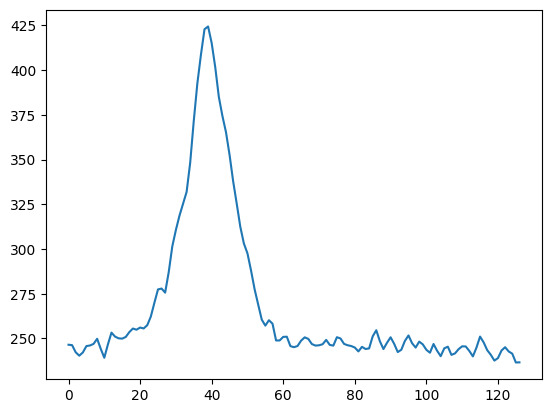

In [85]:
plt.plot(cat1[-1,:,:,0].var(axis=0))

In [93]:
avg = []
for i in range(13):
    avg.append(np.where(cat1[i,:,:,0].var(axis=0)== np.max(cat1[i,:,:,0].var(axis=0)))[0][0])

In [95]:
np.mean(avg)

np.float64(38.84615384615385)

Lets plot the variances of each time value of the 30000 traces for each angle